In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from glob import glob
import itertools
from pao_file_utils import parse_pao_file

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from spherical_harmonics import Y_l, clebsch_gordan_coefficients, test_cg_coeffs

In [3]:
test_cg_coeffs()

In [4]:
def convolute(coords, atom2kind, central_atom, max_l):
    natoms = coords.shape[0]
    assert coords.shape[1] == 3
    kind_names = list(sorted(set(atom2kind)))
    integrals = []
    for l in range(max_l + 1):
        for sigma in [0.5, 1.0, 2.0, 3.0, 4.0]:  #TODO: choose sigmas more thoughtfully
            for ikind in kind_names:
                integrals.append(np.zeros(2*l + 1))
                for iatom in range(natoms):
                    if atom2kind[iatom] == ikind and iatom != central_atom:
                        r = coords[central_atom] - coords[iatom]
                        angular_part = Y_l(r, l)
                        radial_part = np.exp(- np.dot(r,r) / sigma**2)
                        integrals[-1] += radial_part * angular_part
    return integrals

In [5]:
def combinations(channels, max_l):
    """ returns all possbile combinations of input channels up to given max_l """
    output_channels = list()
    for channel_i, channel_j in itertools.combinations_with_replacement(channels, 2):
        assert len(channel_i.shape) == len(channel_j.shape) == 1
        li = (channel_i.size - 1) // 2
        lj = (channel_j.size - 1) // 2
        # There li + lj possible ways to combine the two channels.
        # We do all of them up to a max_l.
        lo_min = abs(li-lj)
        lo_max = min(li+lj, max_l)
        for lo in range(lo_min, lo_max + 1): # l of output
            channel_o = np.zeros(2*lo+1)
            cg = clebsch_gordan_coefficients(li, lj, lo)
            channel_o = np.einsum("i,j,ijo->o", channel_i, channel_j, cg)
            output_channels.append(channel_o)
    return output_channels

In [6]:
# Load training data and hard code metadata.
#pao_files = sorted(glob("2H2O_MD/frame_*/2H2O_pao44-1_0.pao"))
#pao_files = sorted(glob("2H2O_rotations/phi_*/2H2O_pao44-1_0.pao"))
pao_files = sorted(glob("2H2O_rotations/*/2H2O_pao44-1_0.pao"))

prim_basis_shells = {
    'H': [2, 1, 0], # two s-shells, one p-shell, no d-shells
    'O': [2, 2, 1], # two s-shells, two p-shells, one d-shell
}

pao_basis_size = 4

In [33]:
class Sample:
    def __init__(self, channels, xblock, iatom, coords):
        self.channels = channels
        self.xblock = xblock
        self.iatom = iatom # just for debugging
        self.coords = coords # just for debugging
        #TODO generalize
        self.s_channel_list = [c for c in channels if c.size == 1]
        self.p_channel_list = [c for c in channels if c.size == 3]
        self.d_channel_list = [c for c in channels if c.size == 5]

        self.s_channels = np.concatenate(self.s_channel_list)
        self.p_channels = np.stack(self.p_channel_list).T
        if (self.d_channel_list):
            self.d_channels = np.stack(self.d_channel_list).T
        else:
            self.d_channels = np.zeros(shape=[])

def build_dataset(kind_name, max_l):
    samples = []
    for fn in pao_files:
        kinds, atom2kind, coords, xblocks = parse_pao_file(fn)
        natoms = coords.shape[0]
        for iatom in range(natoms):
            if atom2kind[iatom] == kind_name:
                initial_channels = convolute(coords, atom2kind, iatom, max_l)
                if True: # apply combination
                    comb_channels = combinations(initial_channels, max_l)
                    sample = Sample(comb_channels, xblocks[iatom], iatom, coords)
                else:
                    sample = Sample(initial_channels, xblocks[iatom], iatom, coords)
                samples.append(sample)

    print("\nDataset for: ", kind_name)
    print("samples: ", len(samples))
    print("s channels: ", len(samples[0].s_channel_list))
    print("p channels: ", len(samples[0].p_channel_list))
    print("d channels: ", len(samples[0].d_channel_list))
    return samples
    
def samples2xy(samples):
    s_input = np.array([s.s_channels for s in samples], np.float32)
    p_input = np.array([s.p_channels for s in samples], np.float32)
    d_input = np.array([s.d_channels for s in samples], np.float32)
    x_data = [s_input, p_input, d_input]
    y_data = np.array([s.xblock for s in samples], np.float32)
    return x_data, y_data

H_dataset = build_dataset("H", max_l=1)
O_dataset = build_dataset("O", max_l=2)


Dataset for:  H
samples:  224
s channels:  110
p channels:  155
d channels:  0

Dataset for:  O
samples:  112
s channels:  165
p channels:  310
d channels:  310


In [34]:
#TODO implement custom layer instead of Dense + Lambda:
def contract(args):
    assert len(args) == 2
    coeffs = args[0]
    channels = args[1]
    return tf.reduce_sum(coeffs[...,None,:] * channels, axis=-1)

def build_model(first_sample, pao_basis_size, prim_basis_shells, num_hidden_layers, hidden_layers_width):
    
    prim_basis_size = sum([(2*l+1)*n for l, n in enumerate(prim_basis_shells)])
    num_p_channels = len(first_sample.p_channel_list)
    num_d_channels = len(first_sample.d_channel_list)
    
    # define two sets of inputs
    s_input = layers.Input(shape=first_sample.s_channels.shape, name="s_input")
    p_input = layers.Input(shape=first_sample.p_channels.shape, name="p_input")
    d_input = layers.Input(shape=first_sample.d_channels.shape, name="d_input")
    
    #TODO: add more hidden layers
    hidden_out = s_input
    for i in range(num_hidden_layers):
        hidden_out = layers.Dense(hidden_layers_width, activation='softmax', name=f"hidden_layer_{i}")(hidden_out)
            
    pao_output = []
    for i in range(pao_basis_size):
        for l, n in enumerate(prim_basis_shells):
            for j in range(n):
                name = f"{i}{l}{j}"
                if l == 0:
                    s_out = layers.Dense(1, name="coeffs_"+name)(hidden_out)
                    pao_output.append(s_out)
                elif l == 1:
                    p_coeffs = layers.Dense(num_p_channels, name="coeffs_"+name)(hidden_out)
                    contract_layer = layers.Lambda(contract, name="contr_"+name)
                    p_out = contract_layer([p_coeffs, p_input])
                    pao_output.append(p_out)
                elif l == 2:
                    d_coeffs = layers.Dense(num_d_channels, name="coeffs_"+name)(hidden_out)
                    contract_layer = layers.Lambda(contract, name="contr_"+name)
                    d_out = contract_layer([d_coeffs, d_input])
                    pao_output.append(d_out)
                else:
                    raise Exception("Not implemented")
    
    xvec = layers.concatenate(pao_output)
    xblock = layers.Reshape((pao_basis_size, prim_basis_size))(xvec) #TODO: maybe transpose?

    inputs = [s_input, p_input, d_input]
    model = keras.Model(inputs=inputs, outputs=xblock)
    #model.summary()
    return(model)

H_model = build_model(H_dataset[0], pao_basis_size, prim_basis_shells['H'], num_hidden_layers=10, hidden_layers_width=10)
O_model = build_model(O_dataset[0], pao_basis_size, prim_basis_shells['O'], num_hidden_layers=10, hidden_layers_width=10)

In [35]:
def loss_function(xblock_true, xblock_pred):
    #TODO: This might not be ideal as it implicitly forces the predicted basis vectors to be orthonormal.
    projector = tf.matmul(xblock_pred, xblock_pred, transpose_a=True)
    residual = xblock_true - tf.matmul(xblock_true, projector)
    return tf.reduce_mean(tf.pow(residual, 2))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
H_model.compile(optimizer, loss=loss_function)
O_model.compile(optimizer, loss=loss_function)

In [36]:
class TrainingLogger(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.epoch_counter = 0
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_counter += 1
        if self.epoch_counter % 50 == 0:
            print("Epoch: {} Loss: {}".format(self.epoch_counter, logs['loss']))

Epoch: 50 Loss: 0.0009918868308886886
Epoch: 100 Loss: 5.440699169412255e-06
Epoch: 150 Loss: 7.205386509667733e-08
Epoch: 200 Loss: 2.1695982510561151e-10
Epoch: 250 Loss: 8.649011953680563e-13
Epoch: 300 Loss: 2.109909435479753e-14
Epoch: 350 Loss: 4.359706955121617e-15
Epoch: 400 Loss: 2.5555945401057375e-15
Epoch: 450 Loss: 6.757094798921564e-15
Epoch: 500 Loss: 6.86811710138408e-15
Epoch: 550 Loss: 6.965261616038781e-15
Epoch: 600 Loss: 6.734196533741965e-15
Epoch: 650 Loss: 3.812228480213221e-15
Epoch: 700 Loss: 4.717754134673114e-15
Epoch: 750 Loss: 1.5976108646729645e-14
Epoch: 800 Loss: 7.668171483801289e-15
Epoch: 850 Loss: 7.462780393652224e-15
Epoch: 900 Loss: 1.7454787615278633e-14
Epoch: 950 Loss: 8.465450562766819e-15
Epoch: 1000 Loss: 5.846711834025641e-15


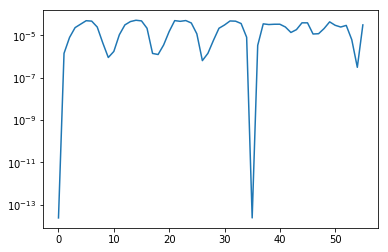

In [37]:
H1_dataset = [s for s in H_dataset if s.iatom==1]
x_train, y_train = samples2xy(H1_dataset[0:1])
H_model.fit(x_train, y_train, epochs=1000, verbose=0, callbacks=[TrainingLogger()]);

losses = []
for s in H1_dataset:
    x_test, y_test = samples2xy([s])
    loss = H_model.evaluate(x_test, y_test, verbose=0)
    losses.append(loss)

plt.yscale('log')
plt.plot(losses);

Epoch: 50 Loss: 0.001694706385023892
Epoch: 100 Loss: 1.0262807336403057e-05
Epoch: 150 Loss: 6.49938911578829e-08
Epoch: 200 Loss: 3.5959740740665325e-10
Epoch: 250 Loss: 1.7686096727767553e-12
Epoch: 300 Loss: 9.686790757544583e-15
Epoch: 350 Loss: 3.50909974058814e-15
Epoch: 400 Loss: 8.803931281236741e-16
Epoch: 450 Loss: 2.7466271512494207e-15
Epoch: 500 Loss: 3.0951596097044103e-15
Epoch: 550 Loss: 2.5681189810220764e-15
Epoch: 600 Loss: 1.5125390047363604e-15
Epoch: 650 Loss: 1.8665010502623685e-15
Epoch: 700 Loss: 4.89703374015717e-15
Epoch: 750 Loss: 8.12313702021057e-16
Epoch: 800 Loss: 1.3410212915435874e-15
Epoch: 850 Loss: 3.249788862357472e-15
Epoch: 900 Loss: 1.442014406273257e-15
Epoch: 950 Loss: 4.654641709773196e-15
Epoch: 1000 Loss: 2.313182392689266e-15


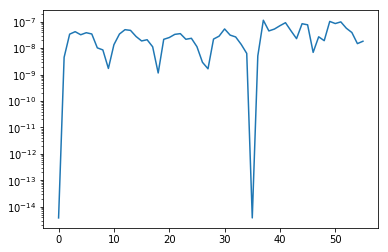

In [38]:
O3_dataset = [s for s in O_dataset if s.iatom==3]
x_train, y_train = samples2xy(O3_dataset[0:1])
O_model.fit(x_train, y_train, epochs=1000, verbose=0, callbacks=[TrainingLogger()]);

losses = []
for s in O3_dataset:
    x_test, y_test = samples2xy([s])
    loss = O_model.evaluate(x_test, y_test, verbose=0)
    losses.append(loss)

plt.yscale('log')
plt.plot(losses);